In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.optimize import minimize
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')


In [3]:
tsla = yf.download('TSLA', start='2015-01-01', end='2024-10-31')

[*********************100%***********************]  1 of 1 completed


In [4]:
tsla

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2015-01-02 00:00:00+00:00,14.620667,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05 00:00:00+00:00,14.006000,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06 00:00:00+00:00,14.085333,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07 00:00:00+00:00,14.063333,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08 00:00:00+00:00,14.041333,14.041333,14.253333,14.000667,14.187333,51637500
...,...,...,...,...,...,...
2024-10-24 00:00:00+00:00,260.480011,260.480011,262.119995,242.649994,244.679993,204491900
2024-10-25 00:00:00+00:00,269.190002,269.190002,269.489990,255.320007,256.010010,161611900


In [5]:
tickers = ['TSLA', 'SPY','BND']
start_date = "2015-01-01"
end_date = "2024-10-31"

In [6]:
data = pd.DataFrame()
for ticker in tickers:
    stock = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
    data[ticker] = stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
print("Dataset Overview:")
print("\nFirst few rows:")
print(data.head())
print("\nBasic information:")
print(data.info())

Dataset Overview:

First few rows:
                                TSLA         SPY        BND
Date                                                       
2015-01-02 00:00:00+00:00  14.620667  173.173767  63.172359
2015-01-05 00:00:00+00:00  14.006000  170.046310  63.355766
2015-01-06 00:00:00+00:00  14.085333  168.444672  63.539230
2015-01-07 00:00:00+00:00  14.063333  170.543640  63.577454
2015-01-08 00:00:00+00:00  14.041333  173.569962  63.478088

Basic information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2474 entries, 2015-01-02 00:00:00+00:00 to 2024-10-30 00:00:00+00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    2474 non-null   float64
 1   SPY     2474 non-null   float64
 2   BND     2474 non-null   float64
dtypes: float64(3)
memory usage: 77.3 KB
None


<Figure size 1500x600 with 0 Axes>

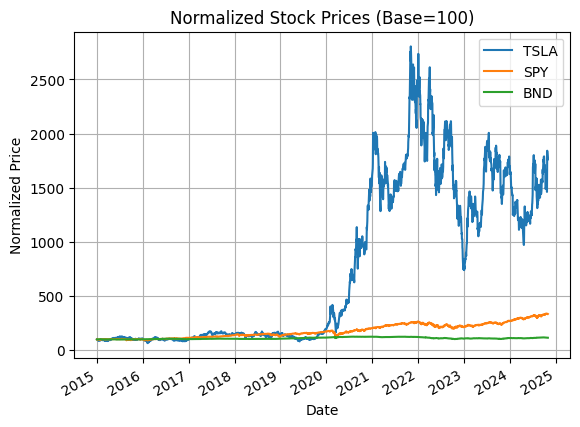

In [8]:
plt.figure(figsize=(15, 6))
normalized_data = data / data.iloc[0] * 100
normalized_data.plot(title='Normalized Stock Prices (Base=100)')
plt.ylabel('Normalized Price')
plt.grid(True)
plt.show()

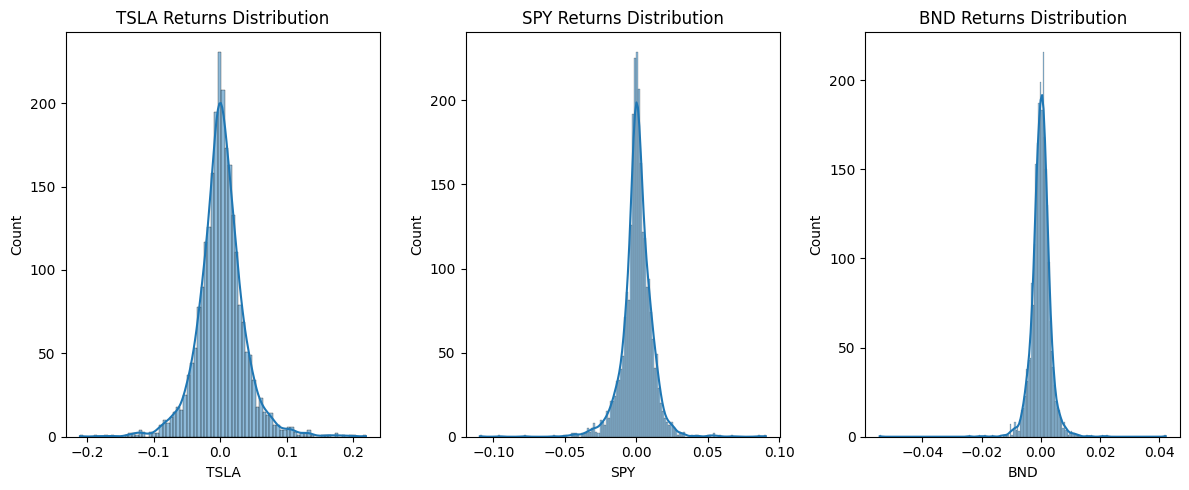

In [12]:
returns = data.pct_change()

# Plot returns distribution
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
for i, ticker in enumerate(tickers):
    sns.histplot(returns[ticker].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'{ticker} Returns Distribution')
plt.tight_layout()
plt.show()


In [15]:
print("\nDaily Returns Statistics:")
print(returns.describe())



Daily Returns Statistics:
              TSLA          SPY          BND
count  2473.000000  2473.000000  2473.000000
mean      0.001799     0.000551     0.000063
std       0.035802     0.011134     0.003430
min      -0.210628    -0.109424    -0.054385
25%      -0.016168    -0.003708    -0.001511
50%       0.001259     0.000596     0.000124
75%       0.018955     0.005933     0.001727
max       0.219190     0.090603     0.042201


In [17]:
# Calculate rolling metrics
window = 21
rolling_mean = returns.rolling(window=window).mean()
rolling_std = returns.rolling(window=window).std()


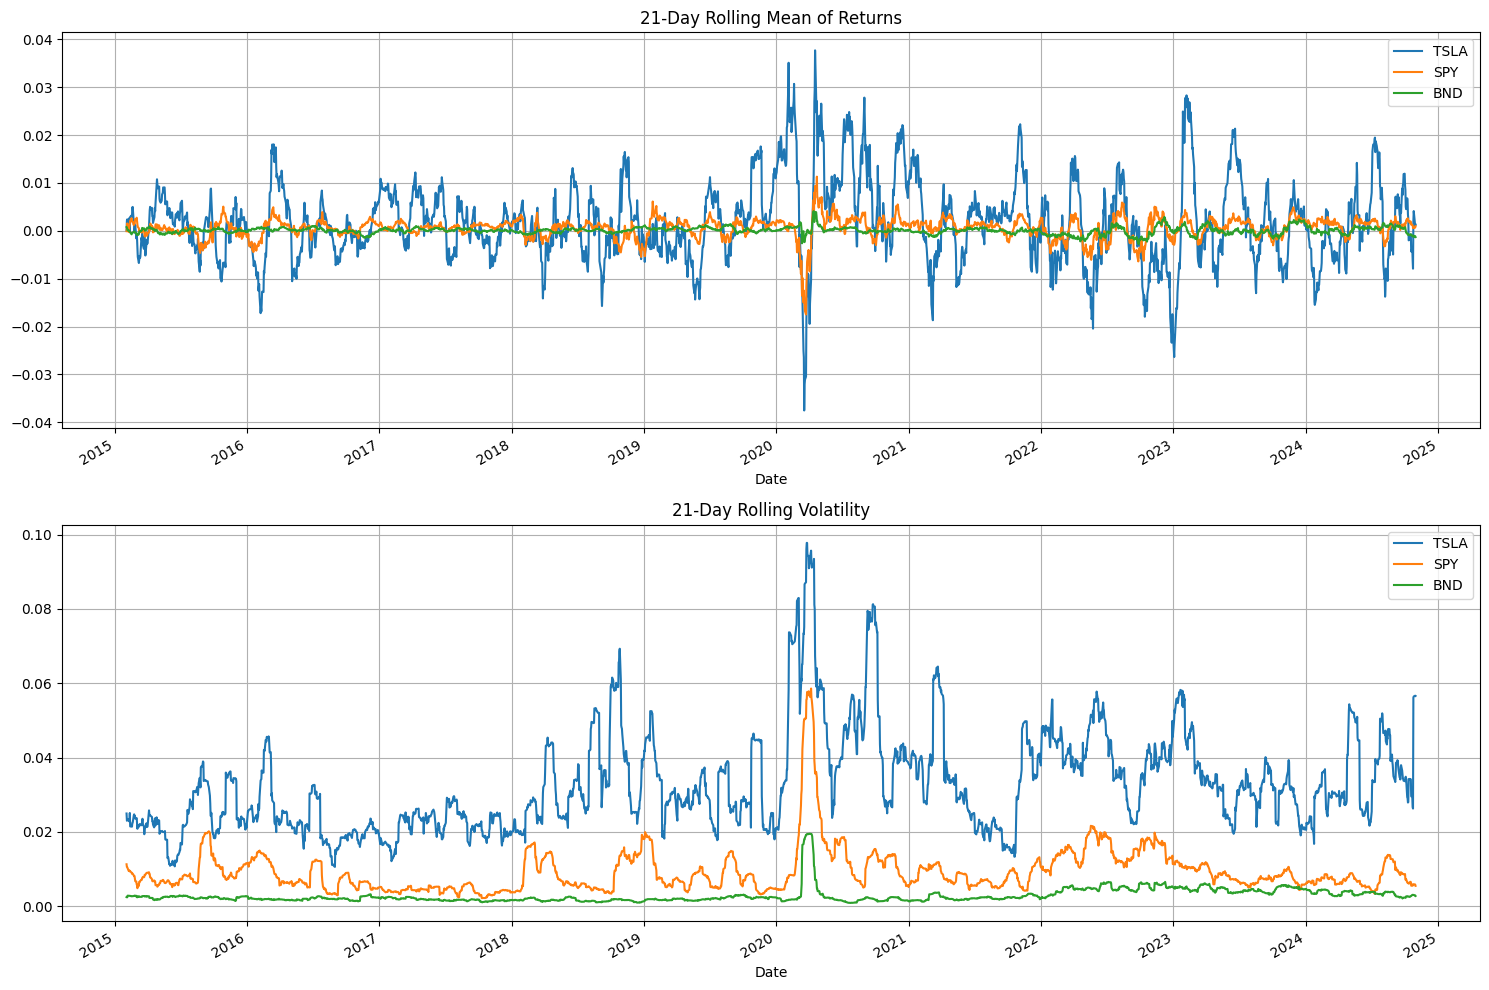

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
# Rolling mean
rolling_mean.plot(ax=axes[0])
axes[0].set_title('21-Day Rolling Mean of Returns')
axes[0].grid(True)

rolling_std.plot(ax=axes[1])
axes[1].set_title('21-Day Rolling Volatility')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Seasonal decompostion 

In [23]:
def plot_decomposition(data, ticker):
    # Perform decomposition
    decomposition = seasonal_decompose(data[ticker], period=21)

    # Plot components
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    # Original
    decomposition.observed.plot(ax=axes[0])
    axes[0].set_title(f'{ticker} Time Series Decomposition')
    axes[0].set_ylabel('Observed')

    # Trend
    decomposition.trend.plot(ax=axes[1])
    axes[1].set_ylabel('Trend')

    # Seasonal
    decomposition.seasonal.plot(ax=axes[2])
    axes[2].set_ylabel('Seasonal')

    # Residual
    decomposition.resid.plot(ax=axes[3])
    axes[3].set_ylabel('Residual')

    plt.tight_layout()
    plt.show()

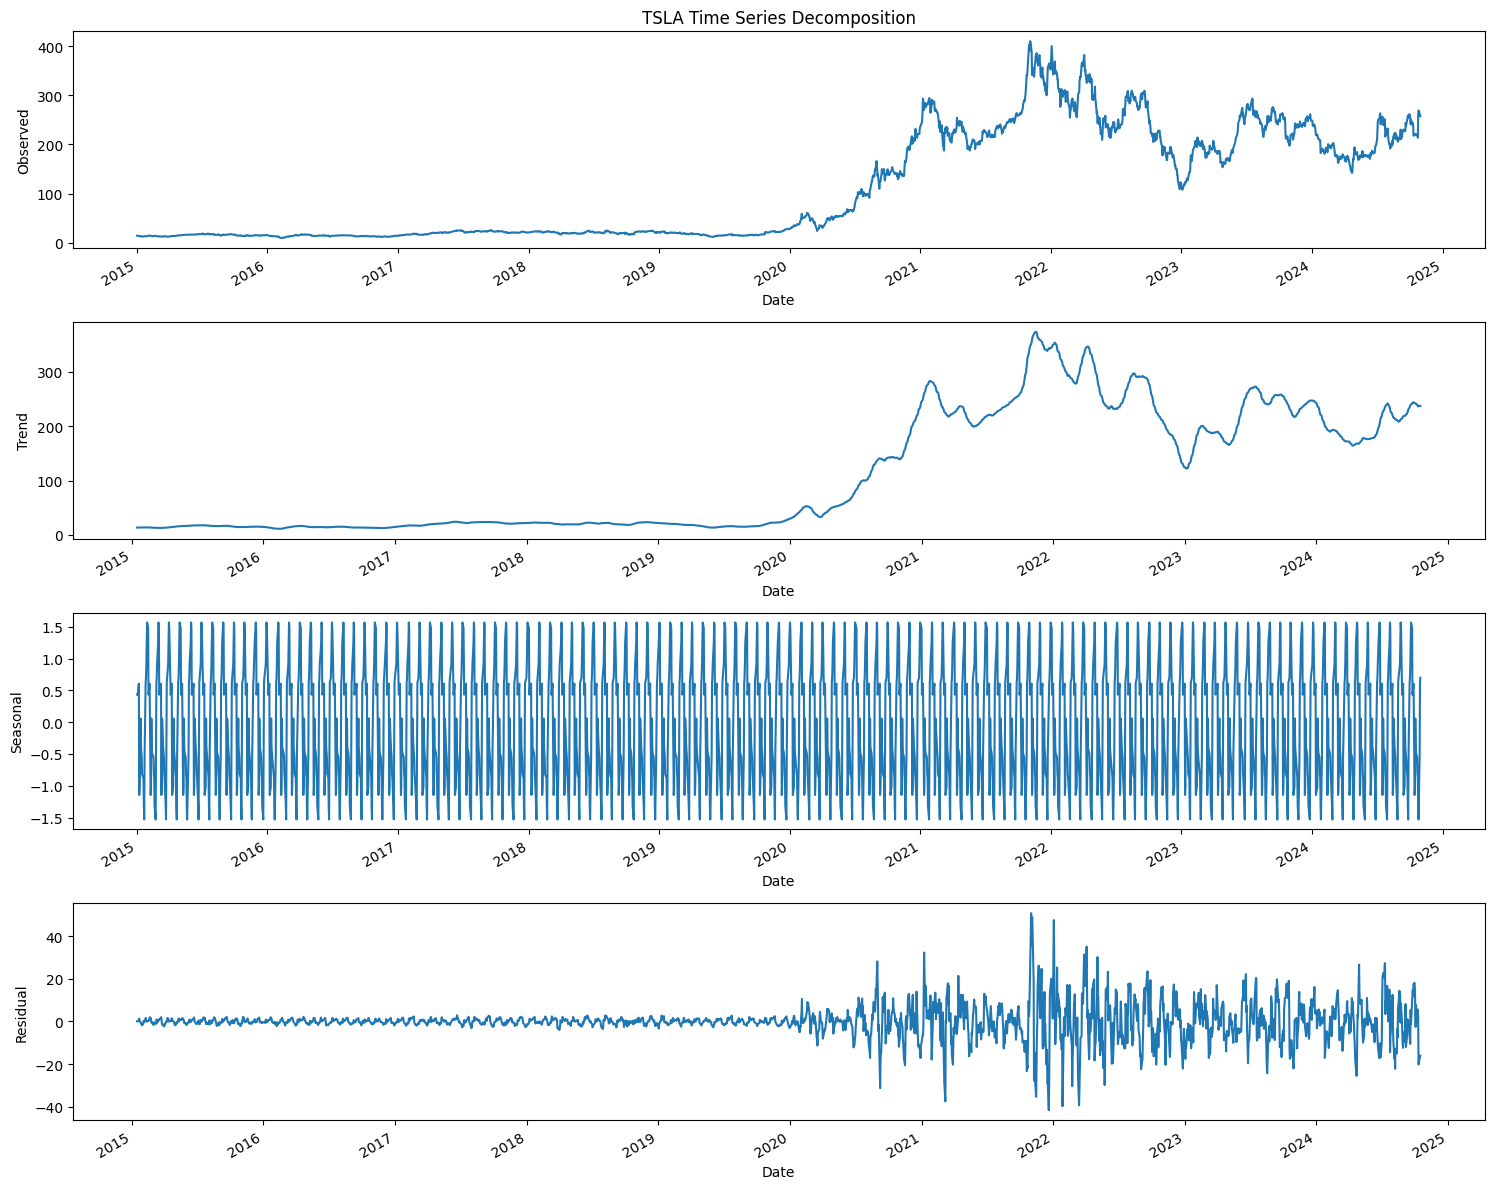

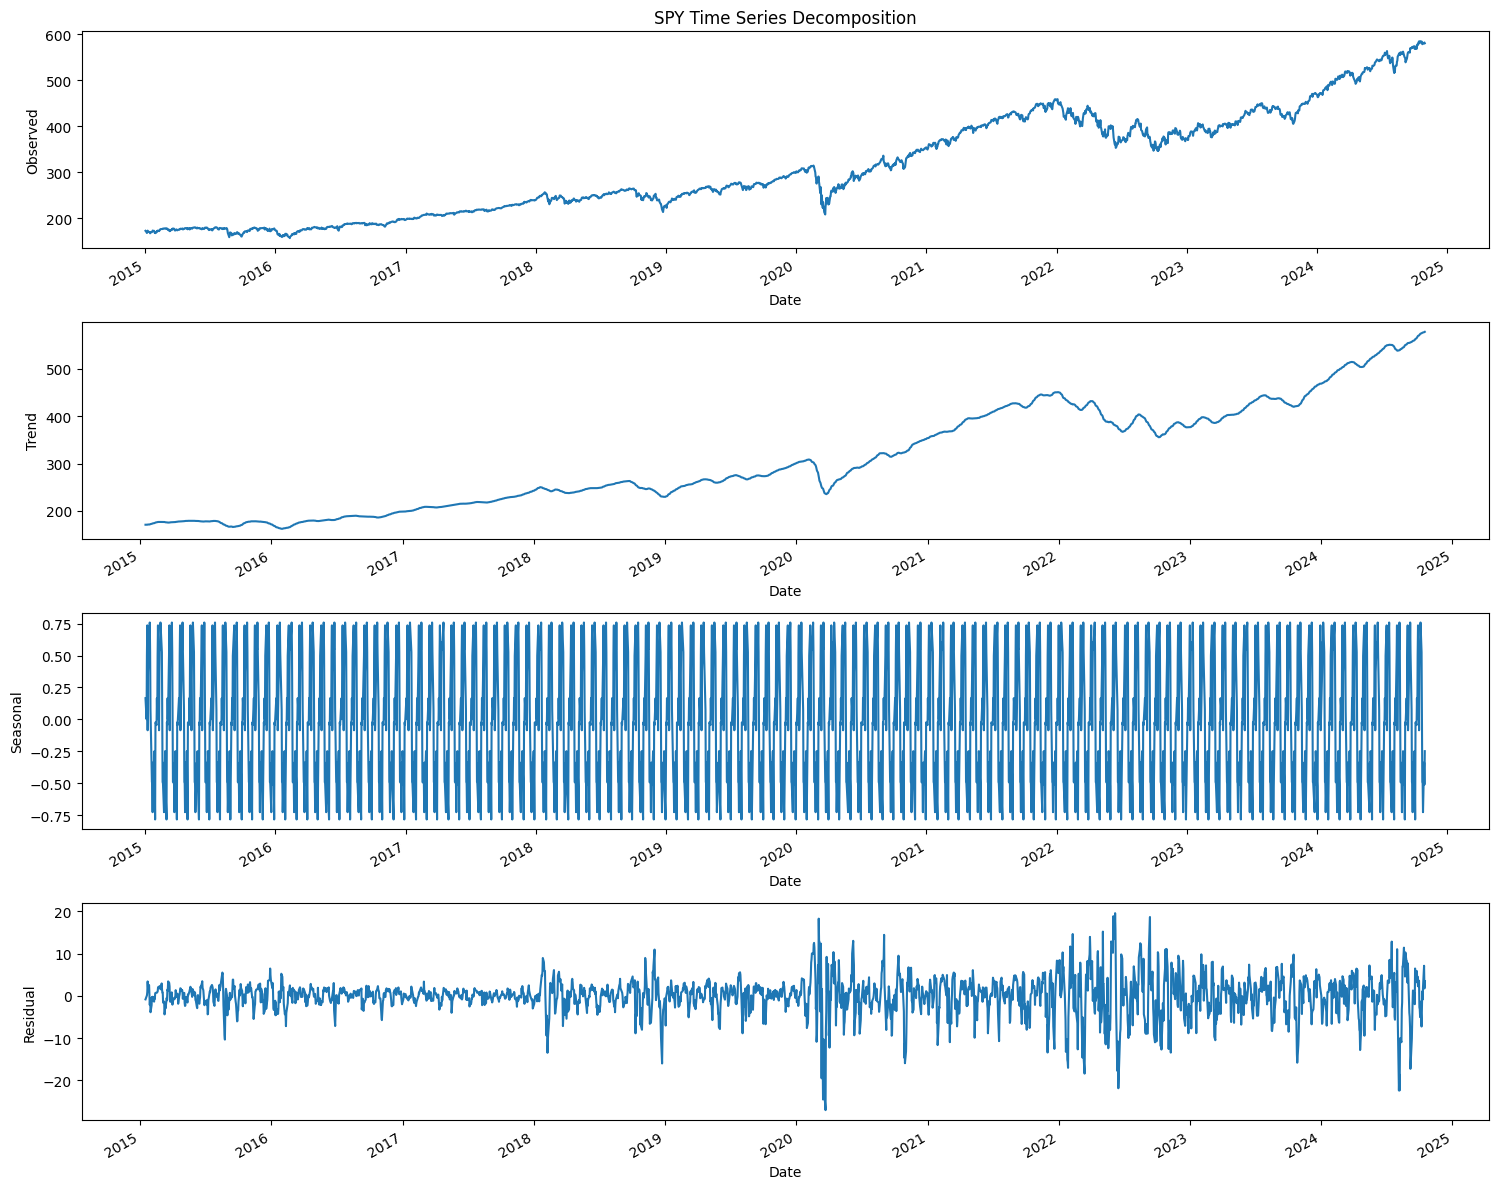

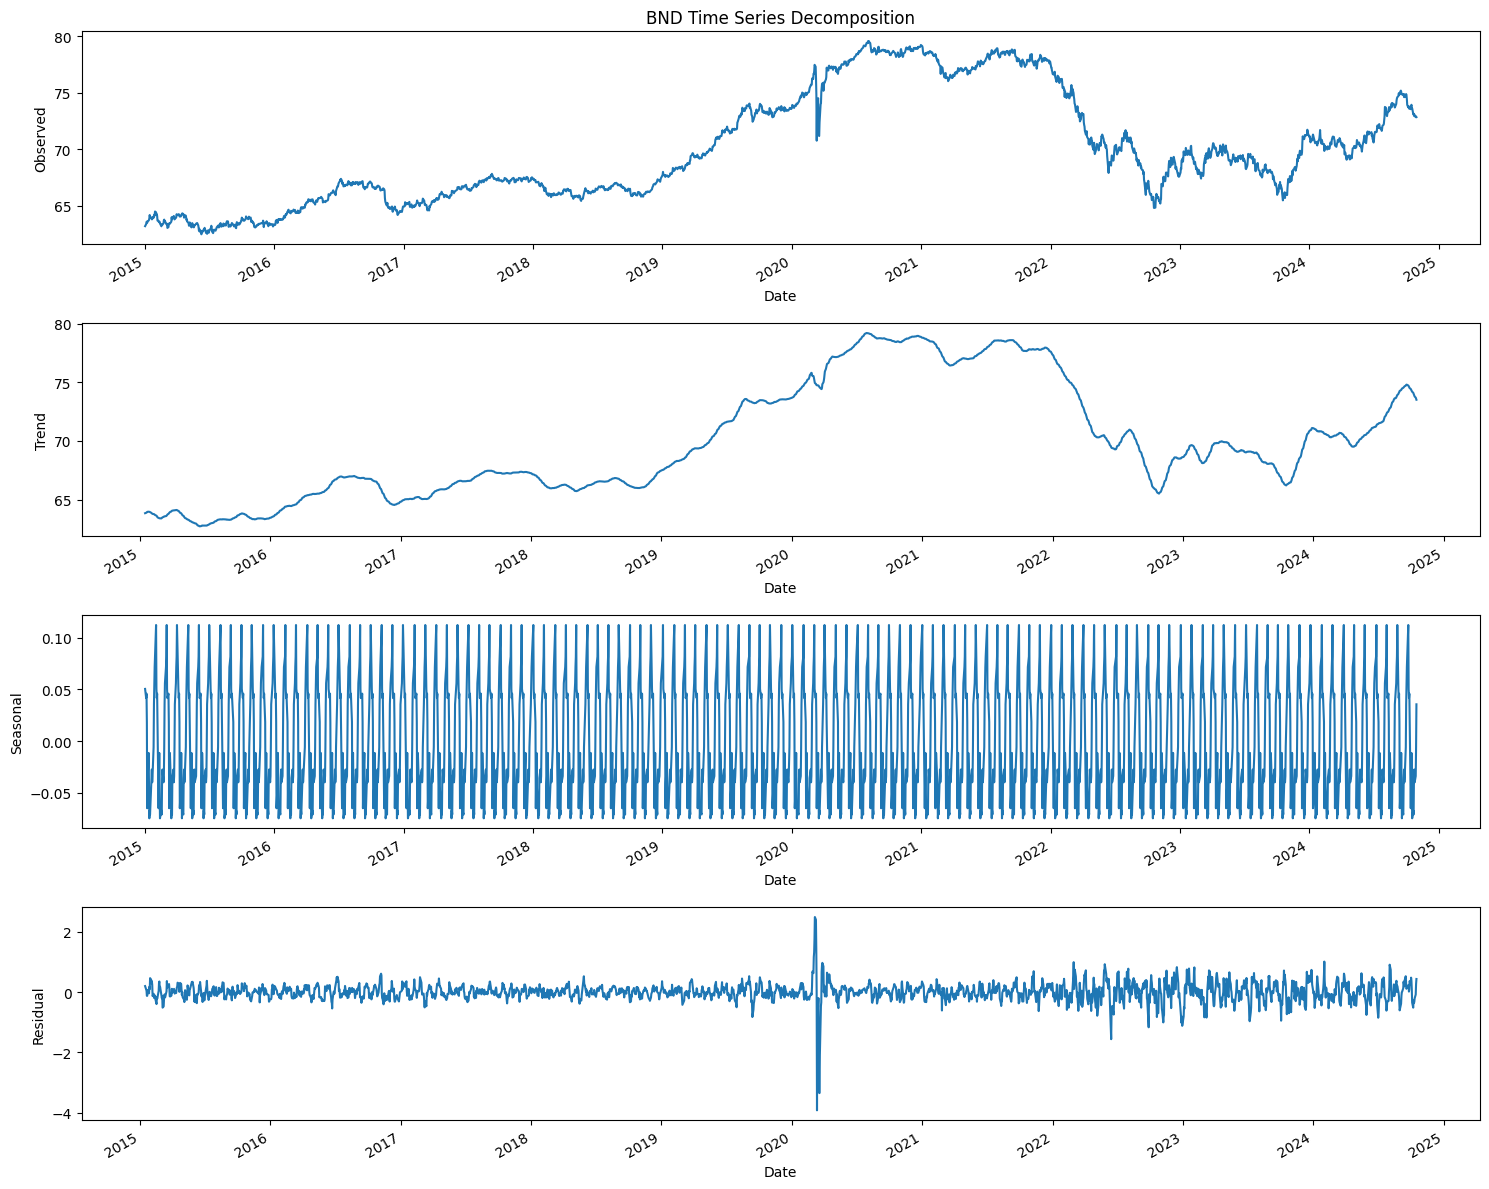

In [ ]:
for ticker in tickers:
    plot_decomposition(data, ticker)

In [24]:
def train_test_split(data, test_size=60):
    """Split data into training and testing sets"""
    return data[:-test_size], data[-test_size:]


In [25]:
def forecast_and_plot(data, ticker, test_size=60):
    # Split data
    train_data, test_data = train_test_split(data[ticker], test_size)

    # Fit SARIMA model
    model = SARIMAX(train_data,
                    order=(1, 1, 1),
                    seasonal_order=(1, 1, 1, 12))
    results = model.fit()

    # Generate forecast
    forecast = results.forecast(test_size)
    conf_int = results.get_forecast(test_size).conf_int()

    # Plot results
    plt.figure(figsize=(15, 8))  # Increased figure height

    # Only plot the last 180 days of training data for better visibility
    lookback_days = 180

    plt.plot(train_data.index[-lookback_days:],
             train_data.values[-lookback_days:],
             label='Training Data',
             color='blue',
             linewidth=2)

    plt.plot(test_data.index,
             test_data.values,
             label='Actual Values',
             color='green',
             linewidth=2)

    plt.plot(test_data.index,
             forecast.values,
             label='Forecast',
             color='red',
             linewidth=2,
             linestyle='--')

    # Customize the plot
    plt.title(f'{ticker} Price Forecast - Last {lookback_days} Days',
              fontsize=14,
              pad=20)

    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)

    # Add grid with custom style
    plt.grid(True, linestyle='--', alpha=0.7)

    # Customize legend
    plt.legend(loc='upper left',
              fontsize=10,
              framealpha=0.9,
              shadow=True)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    plt.show()

    # Calculate error metrics
    mse = np.mean((test_data - forecast) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

    print(f"\nForecast Error Metrics for {ticker}:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Additional statistics
    print(f"\nAdditional Analysis:")
    print(f"Average Forecast Price: ${forecast.mean():.2f}")
    print(f"Forecast Price Range: ${forecast.min():.2f} - ${forecast.max():.2f}")
    print(f"Confidence Interval Width: ${(conf_int.iloc[:, 1] - conf_int.iloc[:, 0]).mean():.2f}")

    return forecast, conf_int

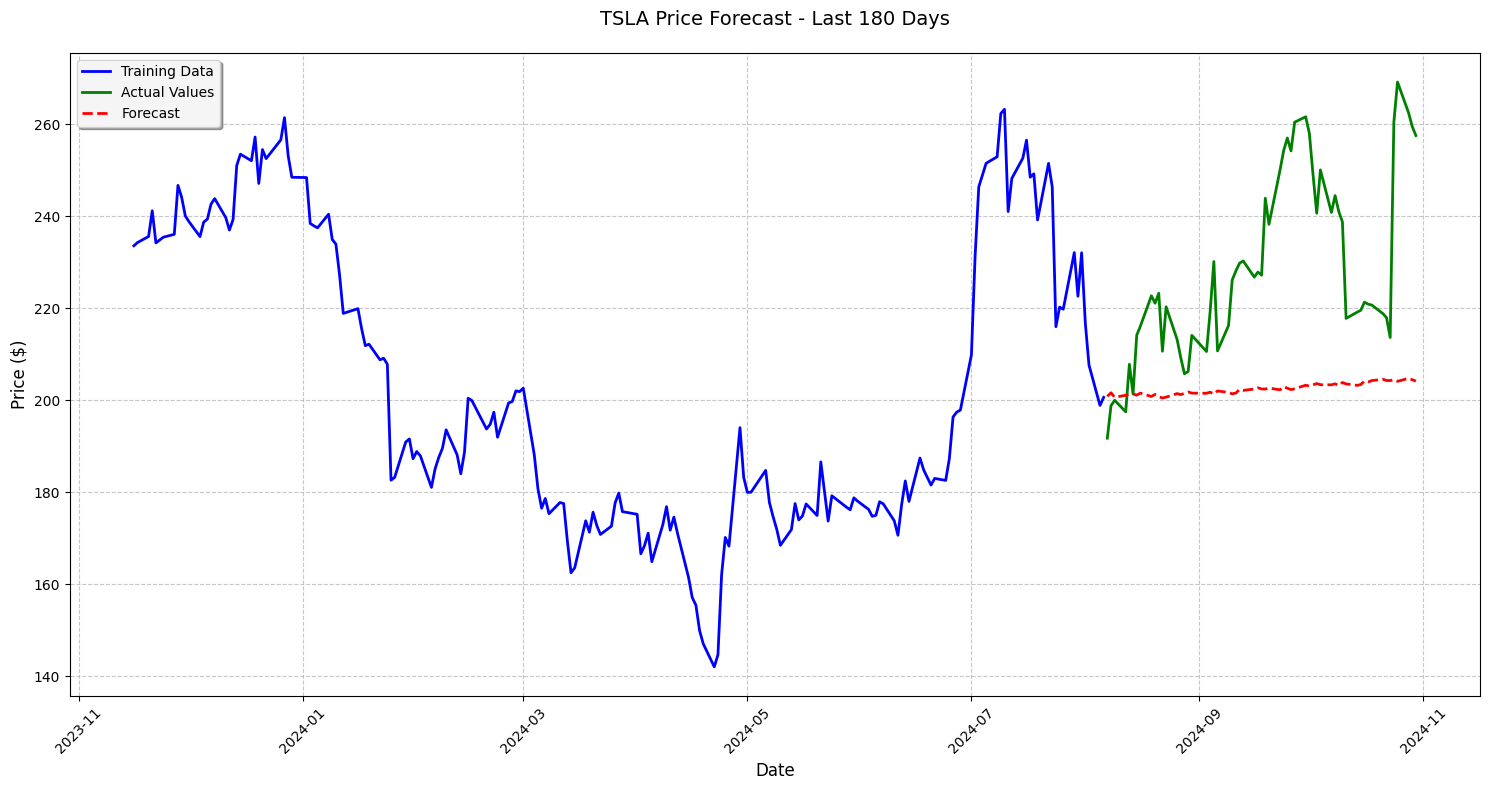


Forecast Error Metrics for TSLA:
RMSE: $nan
MAPE: nan%

Additional Analysis:
Average Forecast Price: $202.52
Forecast Price Range: $200.50 - $204.79
Confidence Interval Width: $119.72


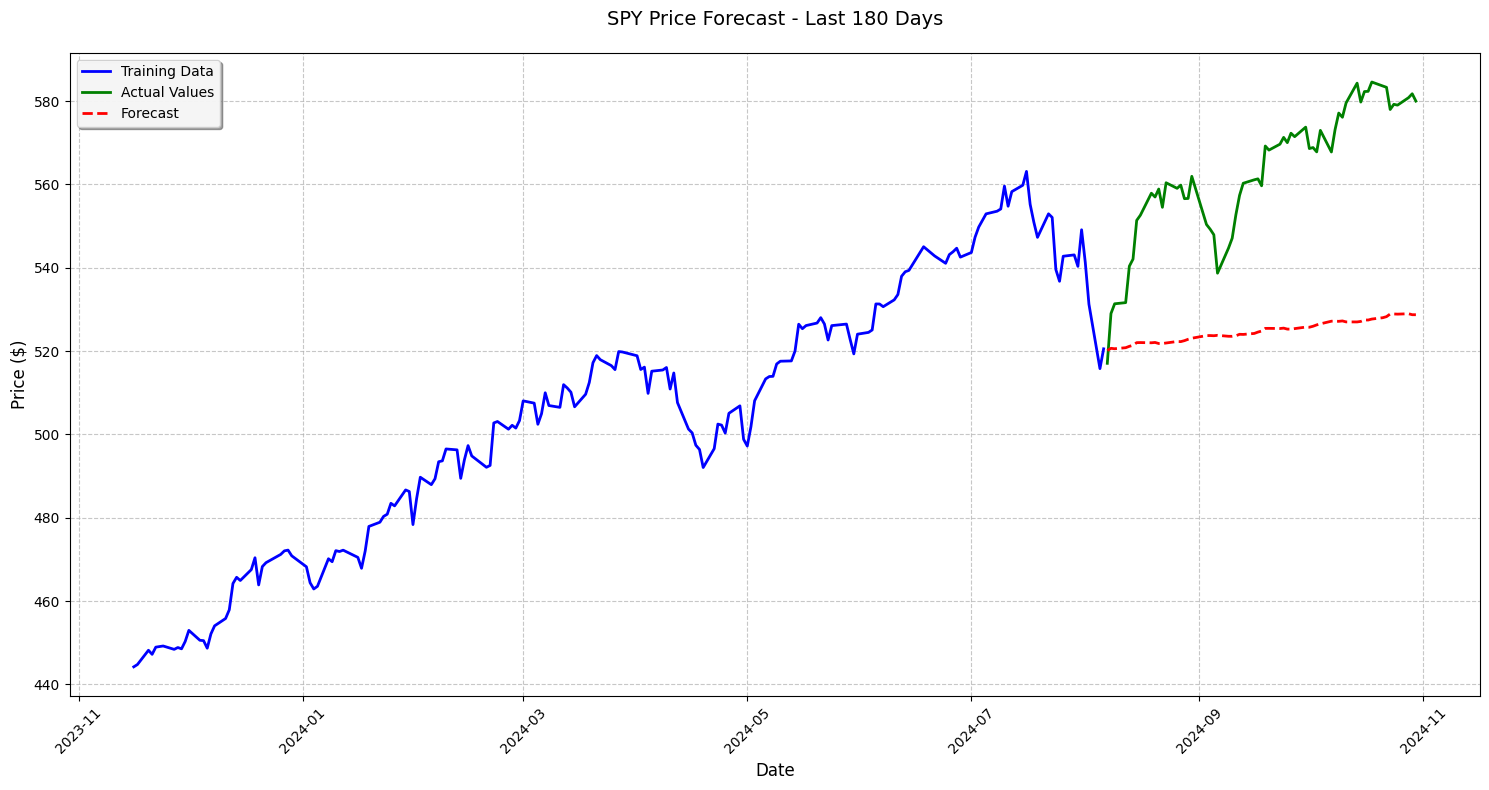


Forecast Error Metrics for SPY:
RMSE: $nan
MAPE: nan%

Additional Analysis:
Average Forecast Price: $524.82
Forecast Price Range: $520.16 - $528.97
Confidence Interval Width: $67.73


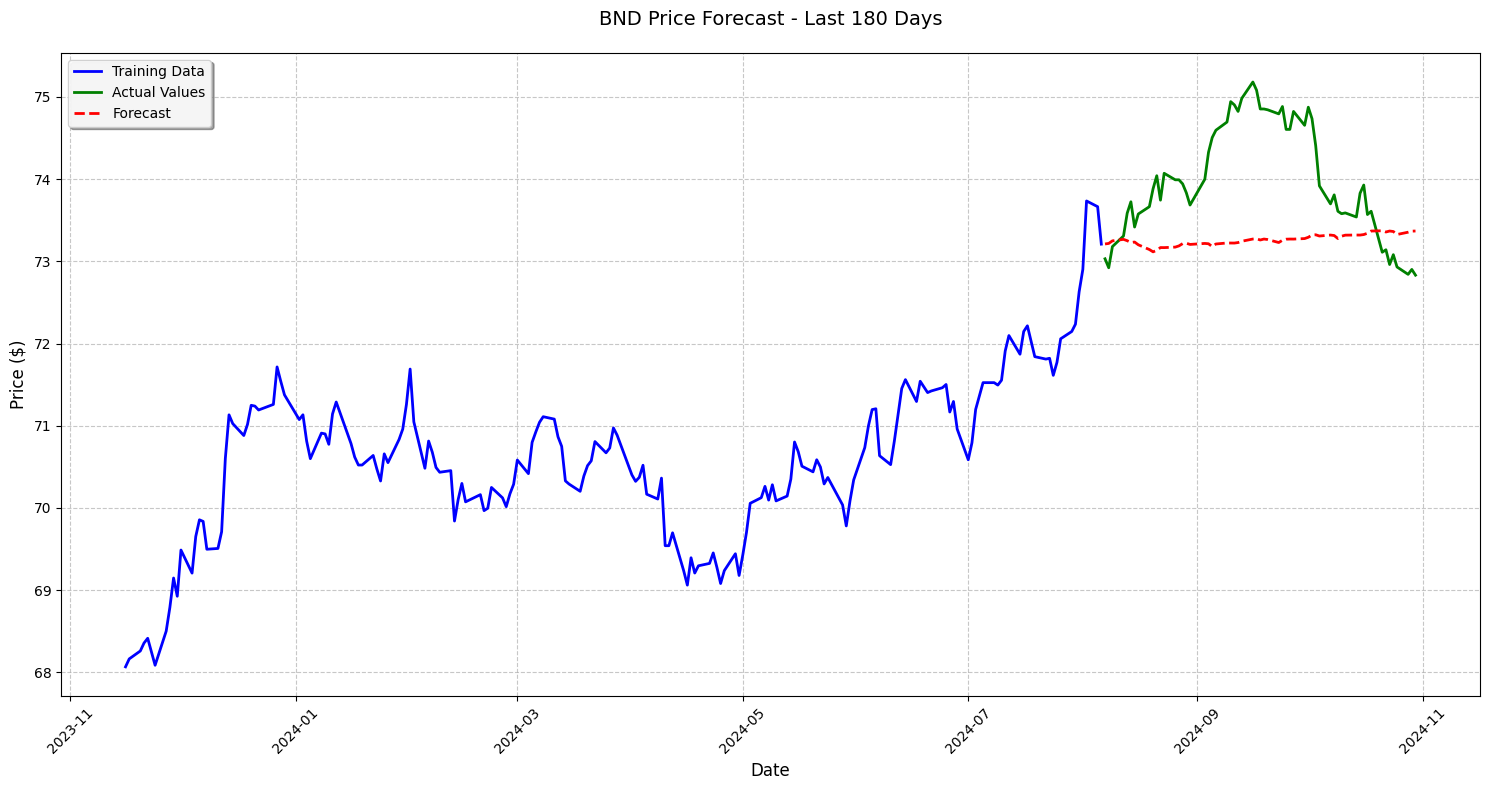


Forecast Error Metrics for BND:
RMSE: $nan
MAPE: nan%

Additional Analysis:
Average Forecast Price: $73.26
Forecast Price Range: $73.12 - $73.37
Confidence Interval Width: $4.43


In [26]:
# Generate forecasts for both stocks
forecasts = {}
for ticker in tickers:
    forecast, conf_int = forecast_and_plot(data, ticker)
    forecasts[ticker] = {'forecast': forecast, 'conf_int': conf_int}

In [27]:
def optimize_portfolio(returns_df, risk_free_rate=0.02):
    """Optimize portfolio using Modern Portfolio Theory"""

    # Calculate annual returns and covariance
    ann_returns = returns_df.mean() * 252
    cov_matrix = returns_df.cov() * 252

    print("Annual Returns:")
    print(ann_returns)
    print("\nCovariance Matrix:")
    print(cov_matrix)

    num_assets = len(returns_df.columns)

    # Define portfolio metrics calculation
    def portfolio_stats(weights):
        weights = np.array(weights)
        portfolio_return = np.sum(ann_returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
        return portfolio_std, portfolio_return, sharpe_ratio

    # Define objective function (negative Sharpe Ratio)
    def neg_sharpe_ratio(weights):
        return -portfolio_stats(weights)[2]

    # Set constraints and bounds
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))

    # Find optimal weights
    initial_weights = [1/num_assets] * num_assets
    result = minimize(neg_sharpe_ratio,
                     initial_weights,
                     method='SLSQP',
                     bounds=bounds,
                     constraints=constraints)

    # Calculate optimal portfolio metrics
    opt_std, opt_ret, opt_sharpe = portfolio_stats(result.x)

    # Print results
    print("\nOptimal Portfolio Weights:")
    for ticker, weight in zip(returns_df.columns, result.x):
        print(f"{ticker}: {weight:.2%}")
    print(f"\nExpected Annual Return: {opt_ret:.2%}")
    print(f"Annual Volatility: {opt_std:.2%}")
    print(f"Sharpe Ratio: {opt_sharpe:.2f}")

    return result.x, opt_ret, opt_std, opt_sharpe

# Optimize portfolio
optimal_weights, opt_ret, opt_std, opt_sharpe = optimize_portfolio(returns)


Annual Returns:
TSLA    0.453361
SPY     0.138885
BND     0.015985
dtype: float64

Covariance Matrix:
          TSLA       SPY       BND
TSLA  0.323013  0.046639  0.001787
SPY   0.046639  0.031238  0.001033
BND   0.001787  0.001033  0.002964

Optimal Portfolio Weights:
TSLA: 30.52%
SPY: 69.48%
BND: 0.00%

Expected Annual Return: 23.49%
Annual Volatility: 25.48%
Sharpe Ratio: 0.84


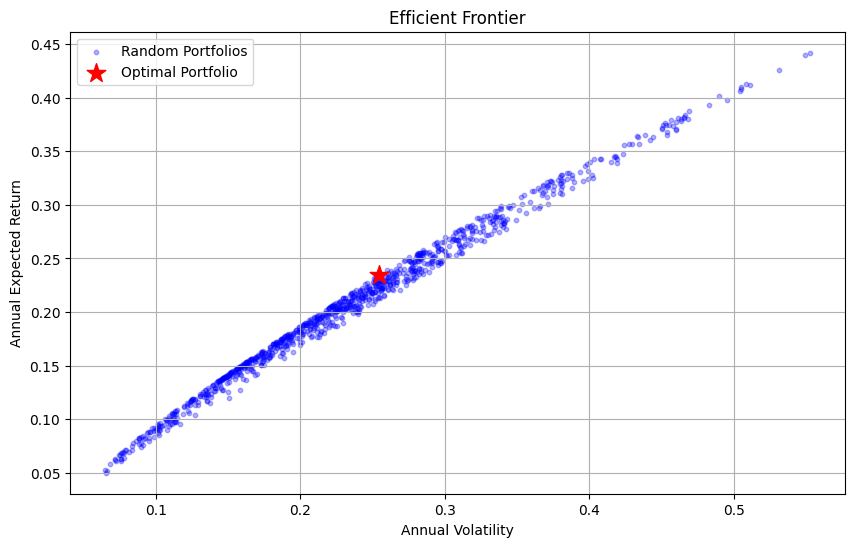

In [28]:
def plot_efficient_frontier(returns_df, optimal_weights, opt_ret, opt_std):
    returns_array = []
    std_array = []

    # Get annualized returns and covariance
    ann_returns = returns_df.mean() * 252
    cov_matrix = returns_df.cov() * 252

    # Generate random portfolios
    for _ in range(1000):
        weights = np.random.random(len(returns_df.columns))
        weights = weights / np.sum(weights)
        portfolio_return = np.sum(ann_returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        returns_array.append(portfolio_return)
        std_array.append(portfolio_std)

    plt.figure(figsize=(10, 6))
    plt.scatter(std_array, returns_array, c='blue', marker='o', s=10, alpha=0.3,
                label='Random Portfolios')
    plt.scatter(opt_std, opt_ret, c='red', marker='*', s=200,
                label='Optimal Portfolio')
    plt.xlabel('Annual Volatility')
    plt.ylabel('Annual Expected Return')
    plt.title('Efficient Frontier')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the efficient frontier
plot_efficient_frontier(returns, optimal_weights, opt_ret, opt_std)

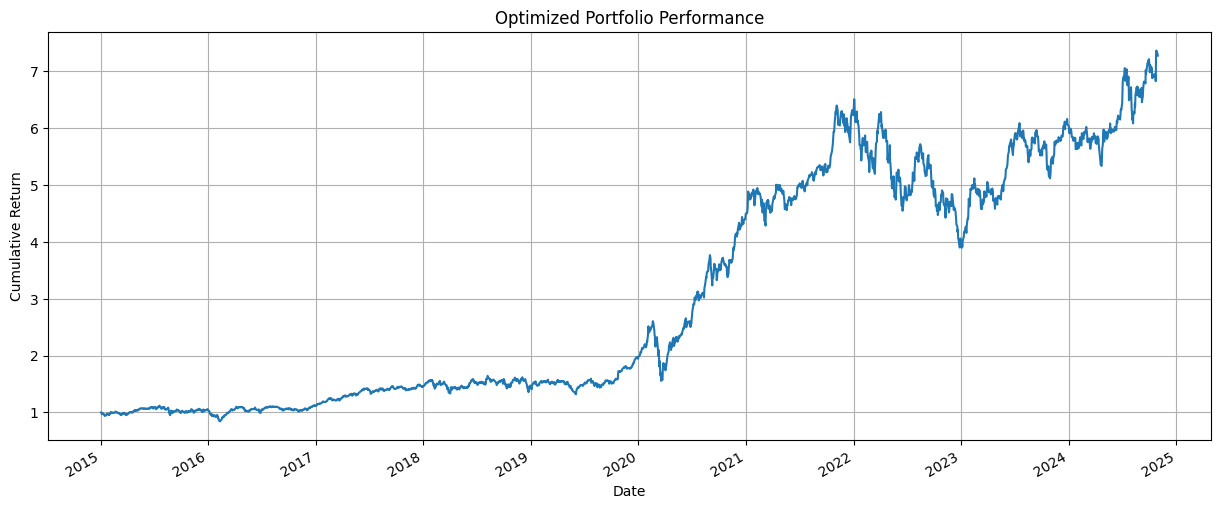


Portfolio Performance Metrics:
Total Return: 627.32%
Annual Volatility: 25.48%
Sharpe Ratio: 0.84
Maximum Drawdown: -40.32%


In [29]:
portfolio_returns = (returns * optimal_weights).sum(axis=1)
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(15, 6))
cumulative_returns.plot(title='Optimized Portfolio Performance')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Calculate performance metrics
print("\nPortfolio Performance Metrics:")
print(f"Total Return: {(cumulative_returns[-1] - 1):.2%}")
print(f"Annual Volatility: {portfolio_returns.std() * np.sqrt(252):.2%}")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")
print(f"Maximum Drawdown: {(cumulative_returns / cumulative_returns.cummax() - 1).min():.2%}")

In [30]:
def enhanced_forecast_with_auto_arima(data, ticker, test_size=60):
    """
    Enhanced version of forecast with auto_arima including more analysis
    """
    # Convert series to array for splitting
    series = data[ticker].values

    # Split data
    train = series[:-test_size]
    test = series[-test_size:]
    train_dates = data.index[:-test_size]
    test_dates = data.index[-test_size:]

    # Fit model
    print(f"\nFitting Auto ARIMA model for {ticker}...")
    model = auto_arima(train,
                      start_p=0, start_q=0,
                      max_p=5, max_q=5, max_d=2,
                      seasonal=True,
                      m=12,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)

    # Generate forecast and confidence intervals
    forecast = model.predict(n_periods=test_size)
    forecast_conf, conf_int = model.predict(n_periods=test_size, return_conf_int=True)

    # Create subplots for detailed analysis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Plot 1: Price and Forecast
    ax1.plot(train_dates[-90:], series[-test_size-90:-test_size], label='Training Data', color='blue')
    ax1.plot(test_dates, test, label='Actual', color='green')
    ax1.plot(test_dates, forecast, label='Forecast', color='red')
    ax1.fill_between(test_dates,
                     conf_int[:, 0],
                     conf_int[:, 1],
                     color='red',
                     alpha=0.1)
    ax1.set_title(f'{ticker} Price Forecast with Confidence Intervals')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Forecast Errors
    errors = test - forecast
    ax2.plot(test_dates, errors, color='red', label='Forecast Errors')
    ax2.axhline(y=0, color='black', linestyle='--')
    ax2.fill_between(test_dates,
                     errors,
                     np.zeros_like(errors),
                     alpha=0.3,
                     color='red' if np.mean(errors) < 0 else 'green')
    ax2.set_title('Forecast Errors (Actual - Predicted)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Calculate error metrics
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    rmse = np.sqrt(np.mean((test - forecast) ** 2))
    mae = np.mean(np.abs(errors))

    print(f'\nError Metrics for {ticker}:')
    print(f'MAPE: {mape:.2f}%')
    print(f'RMSE: ${rmse:.2f}')
    print(f'MAE: ${mae:.2f}')

    return model


In [31]:
def enhanced_future_predictions(models, data, days=30):
    """
    Enhanced future predictions with more detailed analysis
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    predictions = {}
    for ticker in tickers:
        # Get historical data for plotting
        historical = data[ticker].values
        historical_dates = data.index

        # Generate future dates
        last_date = data.index[-1]
        future_dates = pd.date_range(start=last_date, periods=days+1)[1:]

        # Get forecast and confidence intervals
        forecast, conf_int = models[ticker].predict(n_periods=days, return_conf_int=True)
        predictions[ticker] = {'forecast': forecast, 'conf_int': conf_int}

        # Plot 1: Historical and Forecast
        ax1.plot(historical_dates[-60:], historical[-60:],
                label=f'{ticker} Historical', alpha=0.5)
        ax1.plot(future_dates, forecast,
                label=f'{ticker} Forecast', linestyle='--')
        ax1.fill_between(future_dates,
                        conf_int[:, 0],
                        conf_int[:, 1],
                        alpha=0.1)

    ax1.set_title('Price Forecasts with Confidence Intervals')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Expected Returns
    for ticker in tickers:
        returns = np.diff(predictions[ticker]['forecast']) / predictions[ticker]['forecast'][:-1] * 100
        ax2.plot(future_dates[1:], returns, label=f'{ticker} Expected Daily Returns')

    ax2.set_title('Expected Daily Returns During Forecast Period')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Print comprehensive analysis
    print("\nForecast Analysis:")
    for ticker in tickers:
        last_price = data[ticker].values[-1]
        forecast = predictions[ticker]['forecast']
        conf_int = predictions[ticker]['conf_int']

        total_return = (forecast[-1] / last_price - 1) * 100
        max_price = np.max(forecast)
        min_price = np.min(forecast)
        volatility = np.std(np.diff(forecast) / forecast[:-1]) * np.sqrt(252) * 100

        print(f"\n{ticker}:")
        print(f"Expected Return (30 days): {total_return:.1f}%")
        print(f"Price Range: ${min_price:.2f} - ${max_price:.2f}")
        print(f"Confidence Interval (End of Period): ${conf_int[-1,0]:.2f} - ${conf_int[-1,1]:.2f}")
        print(f"Forecast Volatility (Annualized): {volatility:.1f}%")

Starting Enhanced Analysis...

Fitting Auto ARIMA model for TSLA...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=15350.545, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=15352.704, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=15354.257, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=15354.436, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=15351.127, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=15353.927, Time=0.33 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=15353.782, Time=0.28 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=15336.665, Time=2.22 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=15335.080, Time=1.23 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=15335.829, Time=1.89 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=15335.870, Time=1.73 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=15336.303, Time=3.57 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=15333.402, Time=0.37 sec
 ARIM

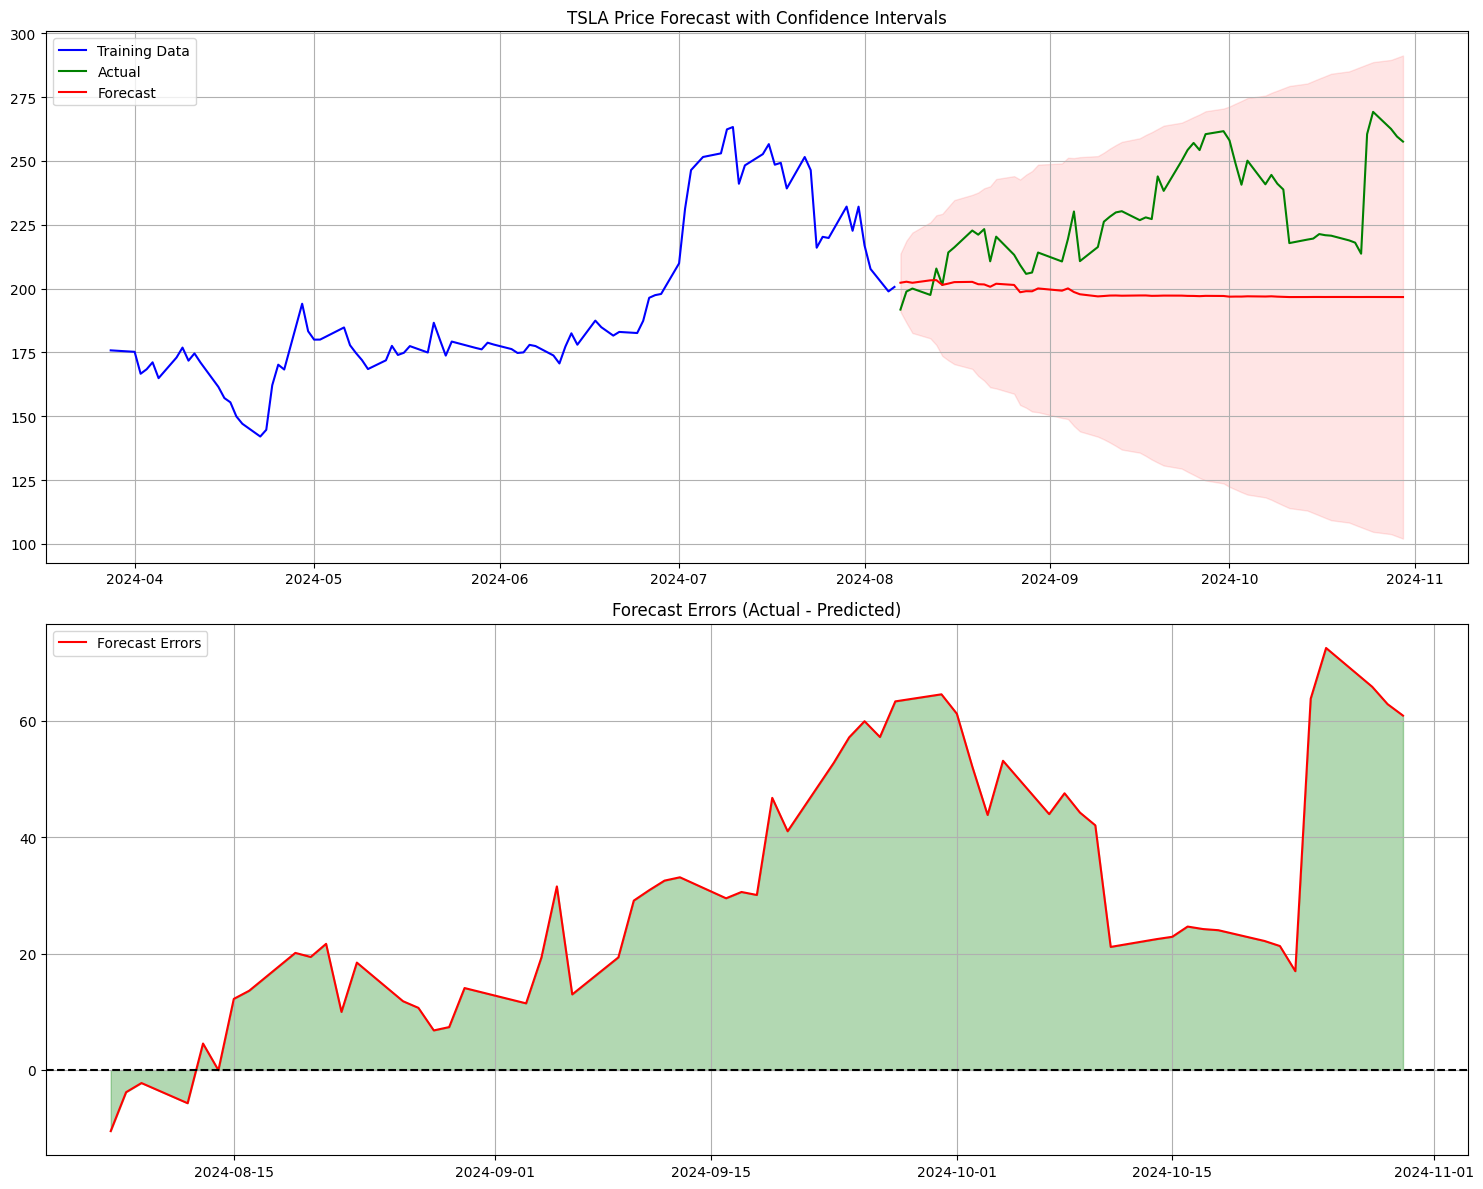


Error Metrics for TSLA:
MAPE: 12.93%
RMSE: $36.82
MAE: $30.99

Fitting Auto ARIMA model for SPY...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=12846.252, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12842.255, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12835.137, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12835.524, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12844.428, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=12833.137, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=12835.137, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=12837.137, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=12834.449, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=12834.382, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=12833.524, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=12812.919, Time=0.56 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AI

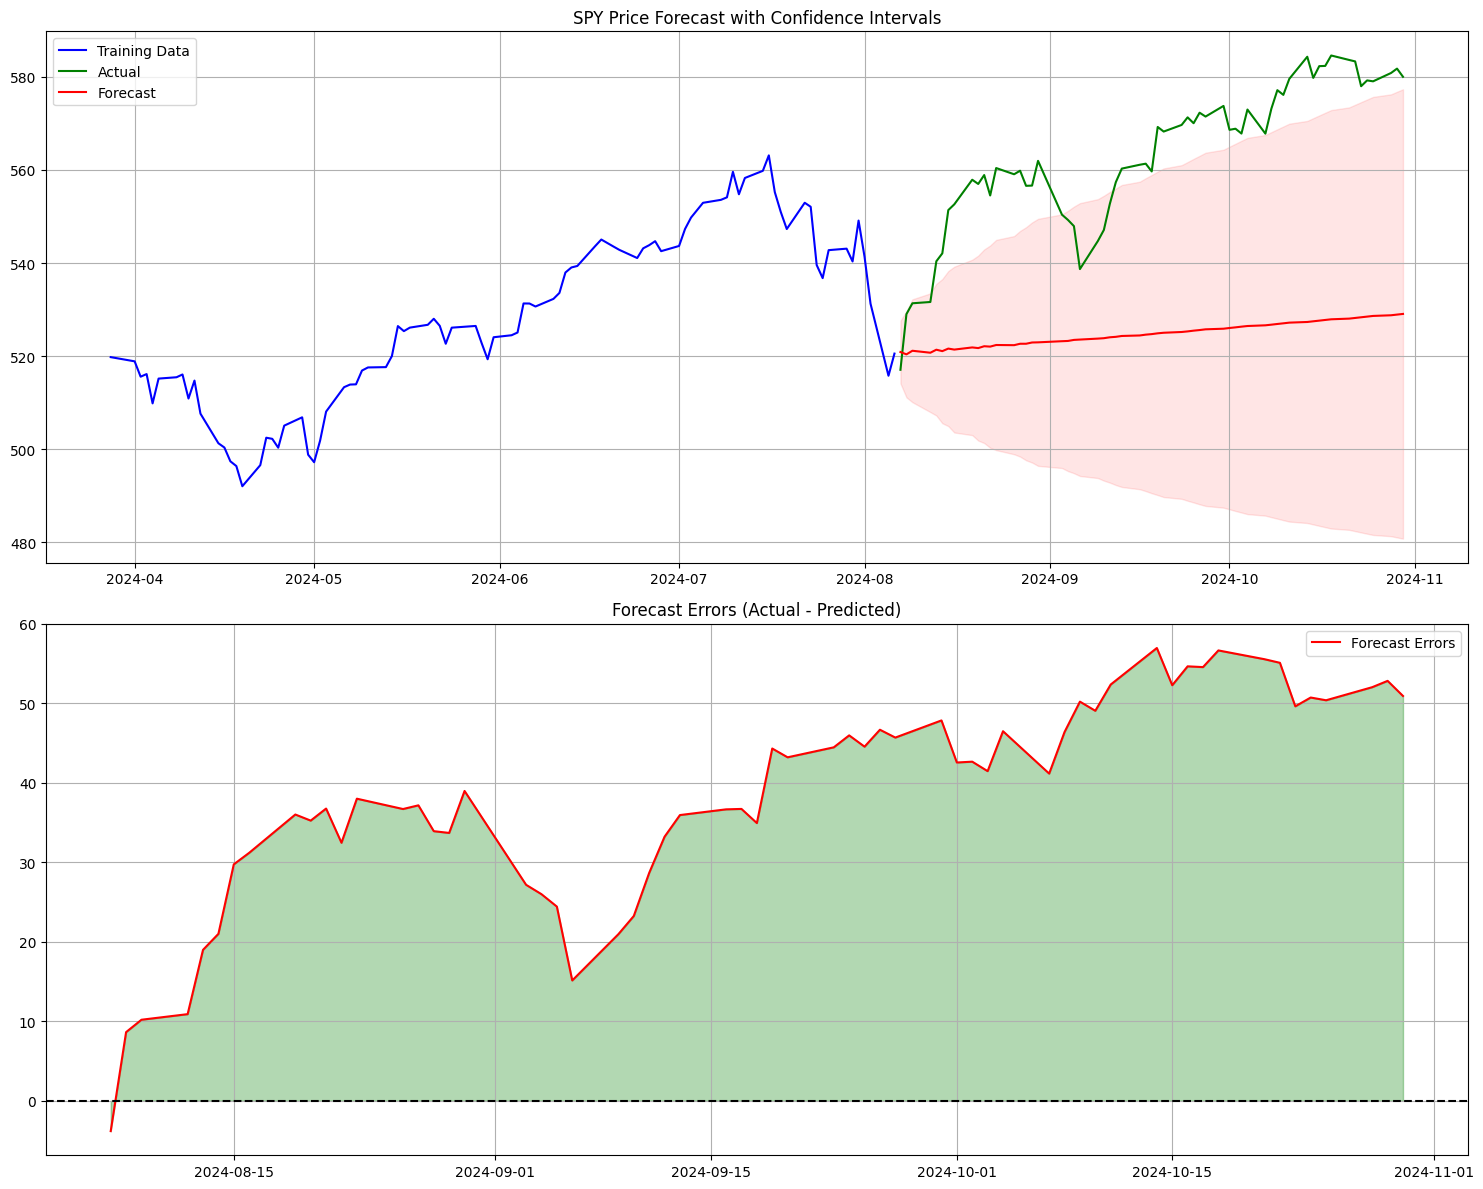


Error Metrics for SPY:
MAPE: 6.76%
RMSE: $40.56
MAE: $38.41

Fitting Auto ARIMA model for BND...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=33.010, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=43.438, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=35.209, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=36.131, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=42.140, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=34.137, Time=0.47 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=33.217, Time=0.36 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=32.966, Time=4.73 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=31.922, Time=1.36 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=33.890, Time=1.47 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=33.882, Time=1.79 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=30.817, Time=3.67 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=31.911, Time=1.38 sec
 ARIMA(1,1,1)(

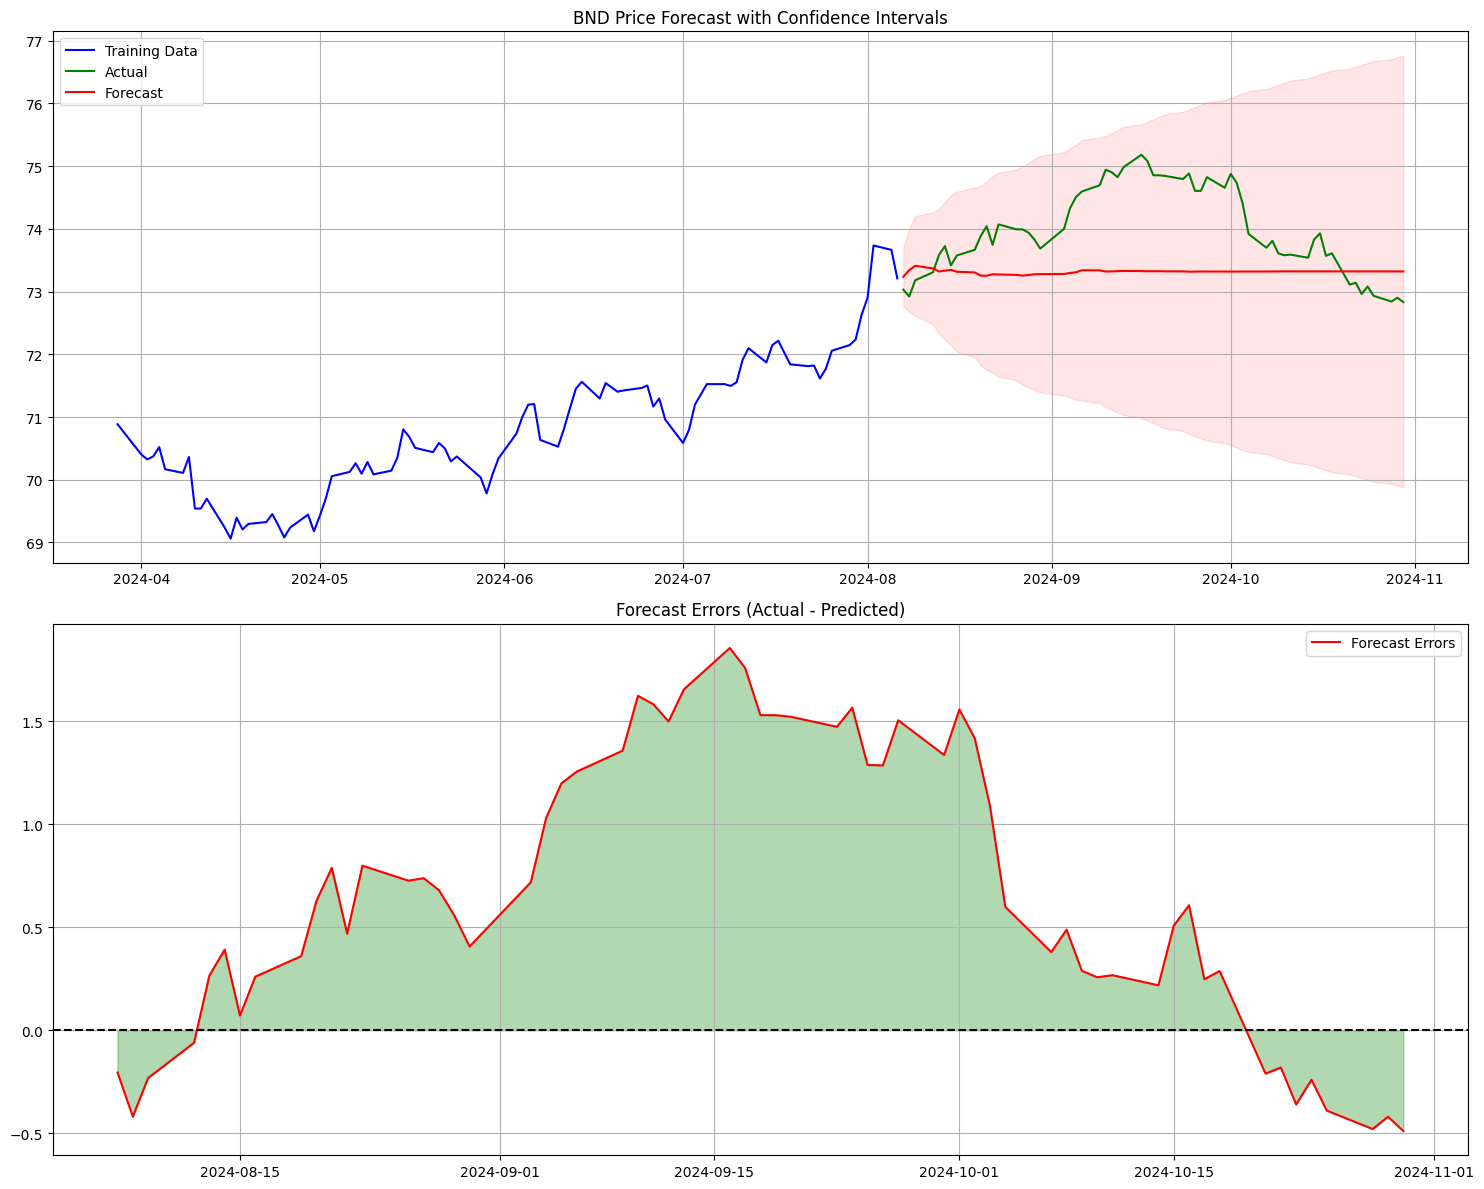


Error Metrics for BND:
MAPE: 1.07%
RMSE: $0.96
MAE: $0.79


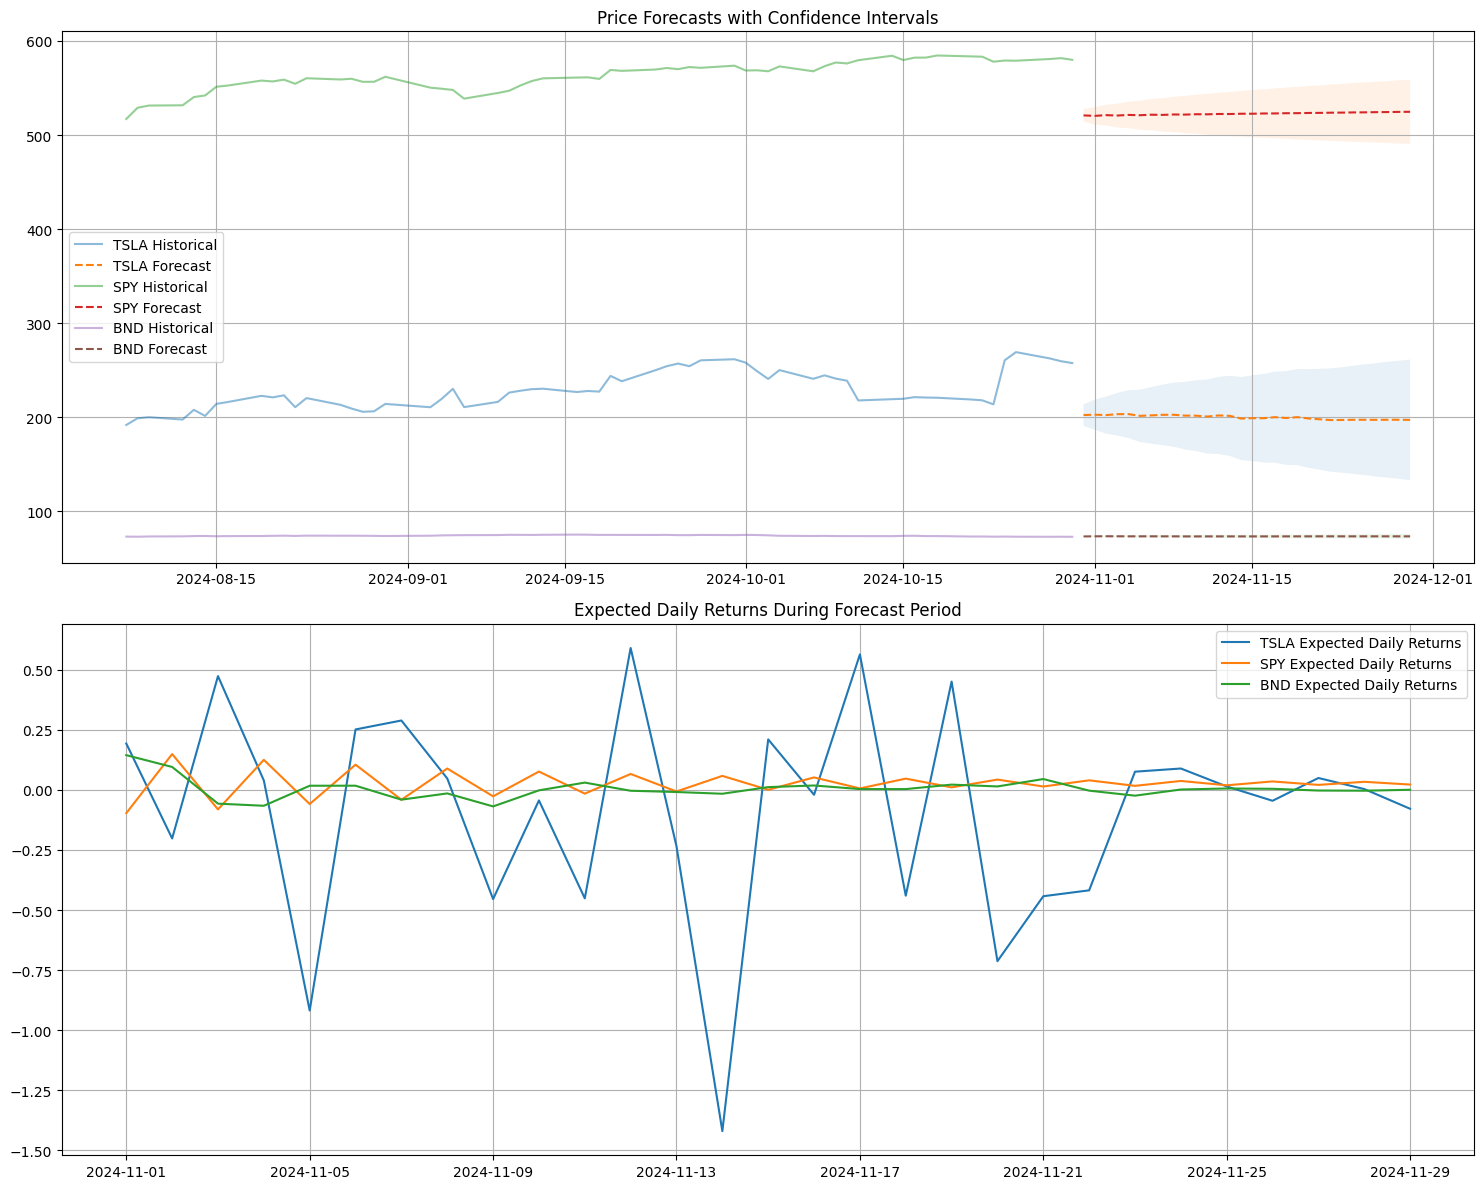


Forecast Analysis:

TSLA:
Expected Return (30 days): -23.5%
Price Range: $196.93 - $203.30
Confidence Interval (End of Period): $133.04 - $261.24
Forecast Volatility (Annualized): 7.0%

SPY:
Expected Return (30 days): -9.5%
Price Range: $520.39 - $524.74
Confidence Interval (End of Period): $490.56 - $558.92
Forecast Volatility (Annualized): 0.9%

BND:
Expected Return (30 days): 0.7%
Price Range: $73.24 - $73.41
Confidence Interval (End of Period): $70.90 - $75.75
Forecast Volatility (Annualized): 0.7%


In [32]:
# Run enhanced analysis
print("Starting Enhanced Analysis...")
models = {}
for ticker in tickers:
    models[ticker] = enhanced_forecast_with_auto_arima(data, ticker)

enhanced_future_predictions(models, data)